**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. XGBoost (eXtra Gradient Boost)

XGBoost는 GBM을 기반으로 하지만, GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결한다.

또한 조기 중단, 자체 내장된 교차 검증 기능, 결손값 자체 처리 등의 기능이 있다.

XGB는 파이썬 래퍼와 사이킷런 래퍼 두 가지 방법으로 구현 가능하다.

## 1.1 파이썬 래퍼 XGBoost

### 1.1.1 하이퍼 파라미터

**일반 파라미터**

>일반적으로 실행 시 스레드의 갯수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없다.

- **booster**: gbtree 또는 gblinear 중 선택, 디폴트는 gbtree


- **silent**: 디폴트는 0이며, 출력 메시지를 나타내고 싶지 않은 경우 1로 설정


- **nthread**: CPU의 실행 스레드 개수로 디폴트는 전체 CPU의 스레드를 사용한다.

**부스터 파라미터**

>트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭한다.

- **eta [defalut: 0.3, alias: learning_rate]**: GBM의 학습률(learning_rate)와 같은 파라미터로 보통 0.01 ~ 0.2 사이의 값을 선호한다.
      
      
- **num_boost_round**: GBM의 n_estimators와 같은 파라미터


- **min_child_weight [default: 1]**: 트리에서 추가적으로 가지를 나눌지 결정하기 위해 필요한 데이터들의 가중치 총합

                             값이 클수록 분할을 자제한다. 과적합을 조절하기 위해 사용
                 
                 
- **gamma [default: 0, aias: min_split_loss]**: 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값

                              해당 값보다 큰 손실(loss)이 감소된 경우 리프 노드를 분리하며 값이 클수록 과적합 감소 효과가 있다.


- **max_depth [default: 6]**: 트리 기반 알고리즘의 max_depth와 같다. 0을 지정하면 깊이 제한이 없다.

                       보통은 3 ~ 10 사이의 값을 적용한다.
              

- **sub_sample [default: 1]**: GBM의 subsample과 같은 파라미터로 일반적으로 0.5 ~ 1 사이의 값을 사용한다.
              
              
- **colsample_bytree [default: 1]**: GBM의 max_features와 유사하다. 트리 생성에 필요한 피처를 임의로 샘플링 하는데 사용

                             피처가 매우 많은 경우 과적합을 조절하는데 사용
                   

- **lambda [default: 1, alias: reg_lambda]**: L2 Regularization 적용 값으로 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.


- **alpha [default: 0, alias: reg_alpha]**: L1 Regularization 적용 값으로 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.


- **scale_pos_weight [default: 1]**: 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 셋의 균형 유지를 위한 파라미터

**학습 태스크 파라미터**

>학습 수행시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

- **objective**: 최솟값을 가져야할 손실함수를 정의한다. 주로 사용하는 손실함수는 이진 분류인지 다중분류인지에 따라 다르다.


- **binary:logistic**: 이진 분류일 때 사용


- **multi:softmax**: 다중 분류일 때 적용, 손실함수가 multi:softmax인 경우에는 레이블 클래스 개수인 num_class 파라미터를 지정해야 한다.


- **multi:softprob**: multi:softmax와 유사하지만 개별 레이블 클래스의 해당되는 예측 확률을 반환한다.


- **eval_metric**: 검증에 사용되는 함수를 정의한다. 기본값은 회귀의 경우 rmse, 분류인 경우 error이다.


    - rmse: Root Mean Square Error    
    - mae: Mean Absolute Error    
    - logloss: Negative log-likelihood    
    - error: Binary classification error rate (0.5 threshold)    
    - merror: Multiclass classification error rate    
    - mlogloss: Multiclass logloss    
    - auc: Area Under the Curve

**과적합 문제가 심각한 경우**

- eta 값을 낮춘다(0.01 ~ 0.1). eta 값을 낮출 경우 num_boost_rounds는 반대로 높여줘야 한다.


- max_depth 값을 낮춘다.


- min_child_weight 값을 높인다.


- gamma 값을 높인다.


- sub_sample과 colsample_bytree 등을 조정한다.

### 1.1.2 위스콘신 유방암 예측

In [3]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df["target"] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print(dataset.target_names)
print(cancer_df.target.value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


- 타겟 레이블 값은 악성 종양(malignant)이 0값으로 212개, 양성 종양(benign)이 1값으로 357개가 있다.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

- 파이썬 래퍼 XGBoost는 train, test 셋을 위해 별도의 객체인 DMatrix를 생성해야한다.


- DMatrix는 주로 Numpy를 입력 받아 생성한다.

**하이퍼 파라미터 설정**

In [6]:
params = {
    "max_depth": 3, 
    "eta": 0.1, 
    "objective": "binary:logistic", 
    "eval_metric": "logloss"
    # "early_stoppings": 100 
}

num_rounds = 400 # 부스팅 반복 횟수

- early_stoppings를 적용해도 후의 명령어에서 사용되지 않는다는 메시지가 출력되어 제거하였다.


- 수행된다는 가정하에 조기 중단을 수행하려면 eval_set과 eval_metric이 함께 설정되어야 한다.


- eval_set은 성능 평가를 수행할 test 데이터를 설정하며 eval_metric은 성능 평가 함수를 지정한다.

**XGB 학습**

In [7]:
# evals 파라미터에 train, test 셋을 명기하면 평가를 진행하면서 조기 중단을 적용 할 수 있다.
wlist = [(dtrain, "train"), (dtest, "eval")]

# 모델 학습: 사이킷런과 달리 train() 함수에 파라미터를 전달한다.
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,
                      evals = wlist)

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:0.00678	eval-logloss:0.08637
[188]	train-logloss:0.00676	eval-logloss:0.08630
[189]	train-logloss:0.00675	eval-logloss:0.08610
[190]	train-logloss:

[338]	train-logloss:0.00528	eval-logloss:0.08583
[339]	train-logloss:0.00528	eval-logloss:0.08591
[340]	train-logloss:0.00527	eval-logloss:0.08583
[341]	train-logloss:0.00526	eval-logloss:0.08573
[342]	train-logloss:0.00526	eval-logloss:0.08568
[343]	train-logloss:0.00525	eval-logloss:0.08572
[344]	train-logloss:0.00525	eval-logloss:0.08580
[345]	train-logloss:0.00524	eval-logloss:0.08582
[346]	train-logloss:0.00524	eval-logloss:0.08571
[347]	train-logloss:0.00523	eval-logloss:0.08579
[348]	train-logloss:0.00523	eval-logloss:0.08583
[349]	train-logloss:0.00522	eval-logloss:0.08573
[350]	train-logloss:0.00522	eval-logloss:0.08566
[351]	train-logloss:0.00521	eval-logloss:0.08573
[352]	train-logloss:0.00521	eval-logloss:0.08581
[353]	train-logloss:0.00520	eval-logloss:0.08571
[354]	train-logloss:0.00519	eval-logloss:0.08566
[355]	train-logloss:0.00519	eval-logloss:0.08570
[356]	train-logloss:0.00518	eval-logloss:0.08563
[357]	train-logloss:0.00518	eval-logloss:0.08553
[358]	train-logloss:

- 지속적으로 train-logloss와 eval-logloss가 감소한다.

**XGB 예측**

In [8]:
# 예측 확률
pred_probs = xgb_model.predict(dtest)
print("predict() 수행 결과값 10개만 표시")
print(np.round(pred_probs[:10], 3))

# 예측 분류
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print("예측 분류 10개만 표시")
print(f"{preds[:10]}")

predict() 수행 결과값 10개만 표시
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측 분류 10개만 표시
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


- XGB에서 predict는 예측 분류값이 아닌 1로 분류될 예측 확률 값으로 나타난다.

**XGB 평가**

In [9]:
# 3장에서 사용한 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [10]:
get_clf_eval(y_test, pred = preds, pred_proba_po = pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


**XGB 피처별 중요도**

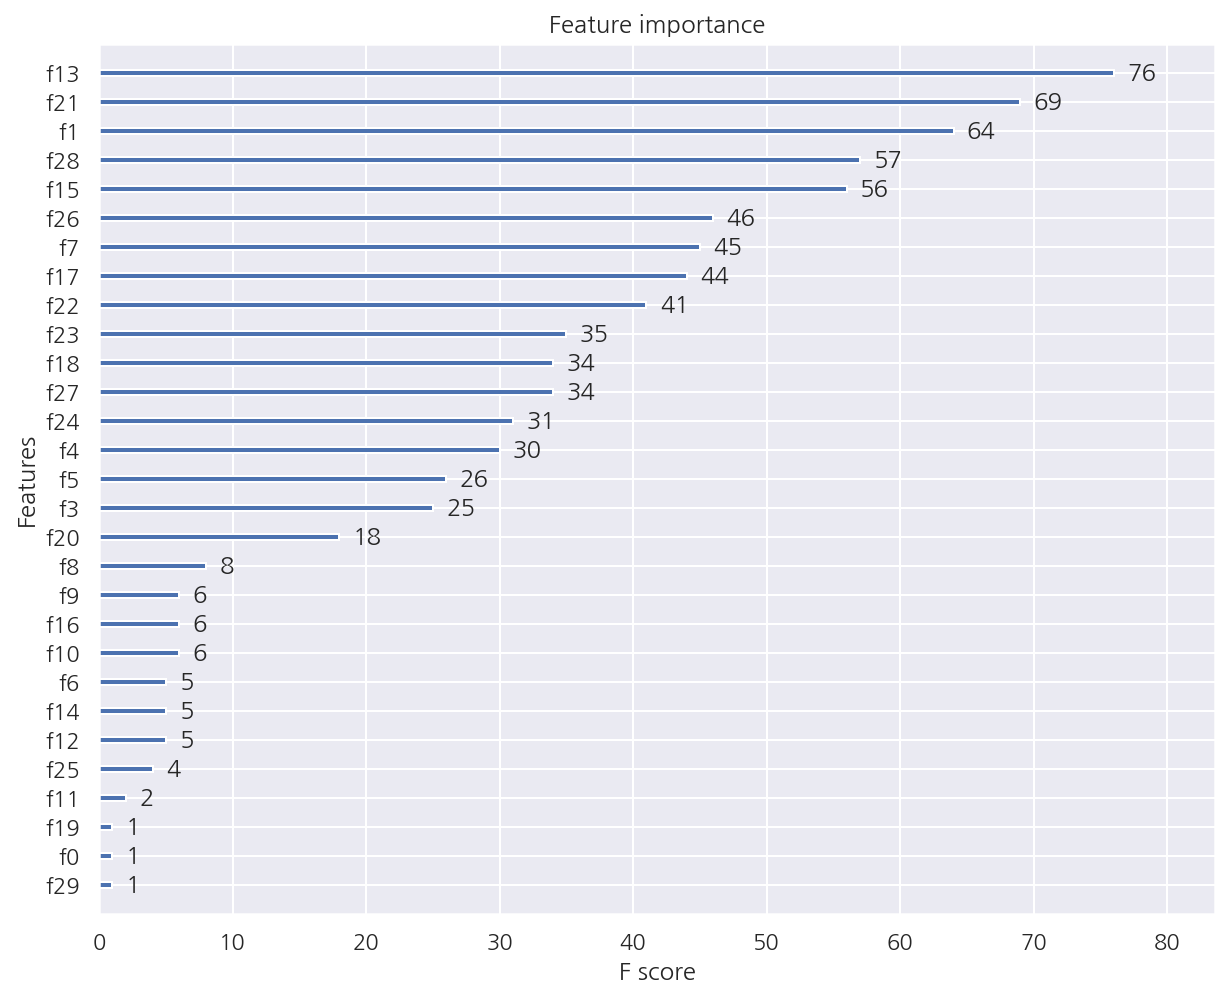

In [11]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

- XGB는 내장 함수 `plot_importance`를 이용해 피처별 중요도를 시각화 할 수 있다.


- 기본 평가 지표는 f1 스코어를 사용하며 유의 할 점은 Numpy 기반의 피처 데이터로 학습 시 피처명을 제대로 알 수 없어 f0,f1 등 순서별로 나타난다.

**XGB 시각화**

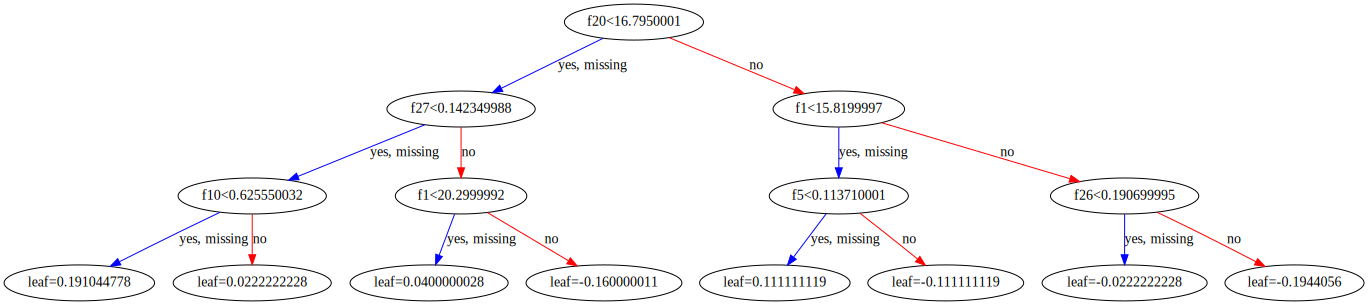

In [12]:
from xgboost import to_graphviz
import graphviz

to_graphviz(xgb_model)

**XGB 교차검증**

In [13]:
xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=3, metrics="logloss")

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.610037,0.000064,0.617448,0.004961
1,0.541817,0.000203,0.555140,0.008989
2,0.483717,0.000955,0.503529,0.012238
3,0.434676,0.001311,0.459869,0.015795
4,0.392310,0.001686,0.423058,0.016788
5,0.355129,0.001390,0.391187,0.019785
6,0.322530,0.001909,0.361119,0.019378
7,0.294159,0.001618,0.337139,0.021085
8,0.269083,0.002068,0.314902,0.019971
9,0.246208,0.001940,0.295012,0.019237


- XGB에선 `cv`를 이용해 교차검증이 가능하다. 부스팅 반복횟수가 증가하면서 logloss가 감소하는 것을 확인 할 수 있다.

## 1.2 사이킷런 래퍼 XGBoost

### 1.2.1 하이퍼 파라미터

>사이킷런 래퍼 XGBoost의 하이퍼 파라미터는 파이썬 래퍼와 일부 차이가 있다.

- eta [defalut: 0.3] $\rightarrow$ learning_rate [defalut: 0.1]
 
 
- sub_sample $\rightarrow$ subsample
              
              
- lambda $\rightarrow$ reg_lambda


- alpha $\rightarrow$ reg_alpha


- num_boost_round $\rightarrow$ n_estimators

### 1.2.2 위스콘신 유방암 예측

In [14]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df["target"] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**XGB 학습/예측/평가**

In [15]:
from xgboost import XGBClassifier

# 파이썬 래퍼와 동일한 하이퍼 파라미터 수치
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)

w_preds = xgb_wrapper.predict(X_test)
w_pred_probs = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = w_preds, pred_proba_po = w_pred_probs)

[15:53:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


- 앞서 파이썬 래퍼 XGBoost와 동일한 결과가 나타난다.

**XGB 조기 중단**

In [16]:
from xgboost import XGBClassifier

# 객체 생성
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 3)

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
xgb_wrapper.fit(X_train, y_train,
                # 조기 중단 파라미터
                early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                verbose=True)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

- 이 예제에선 성능 평가를 수행할 데이터로 test 데이터를 사용하였으나 이 경우 학습시 test 데이터가 미리 참고 될 수 있다.


- 결과를 보면 311번 반복 후 학습을 진행하지 않는다. 


- 이는 211번 반복시 logloss가 0.08559에서 311번 반복시 0.08595로 100번 반복 동안 성능 평가 지수가 향상 되지 않았기 때문이다.

In [17]:
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_probs = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = ws100_preds, pred_proba_po = ws100_pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


- 조기 중단으로 학습된 XGBClassifier로 조기 중단이 적용되지 않은 결과와 큰 차이가 없다.

**XGB 피처별 중요도**

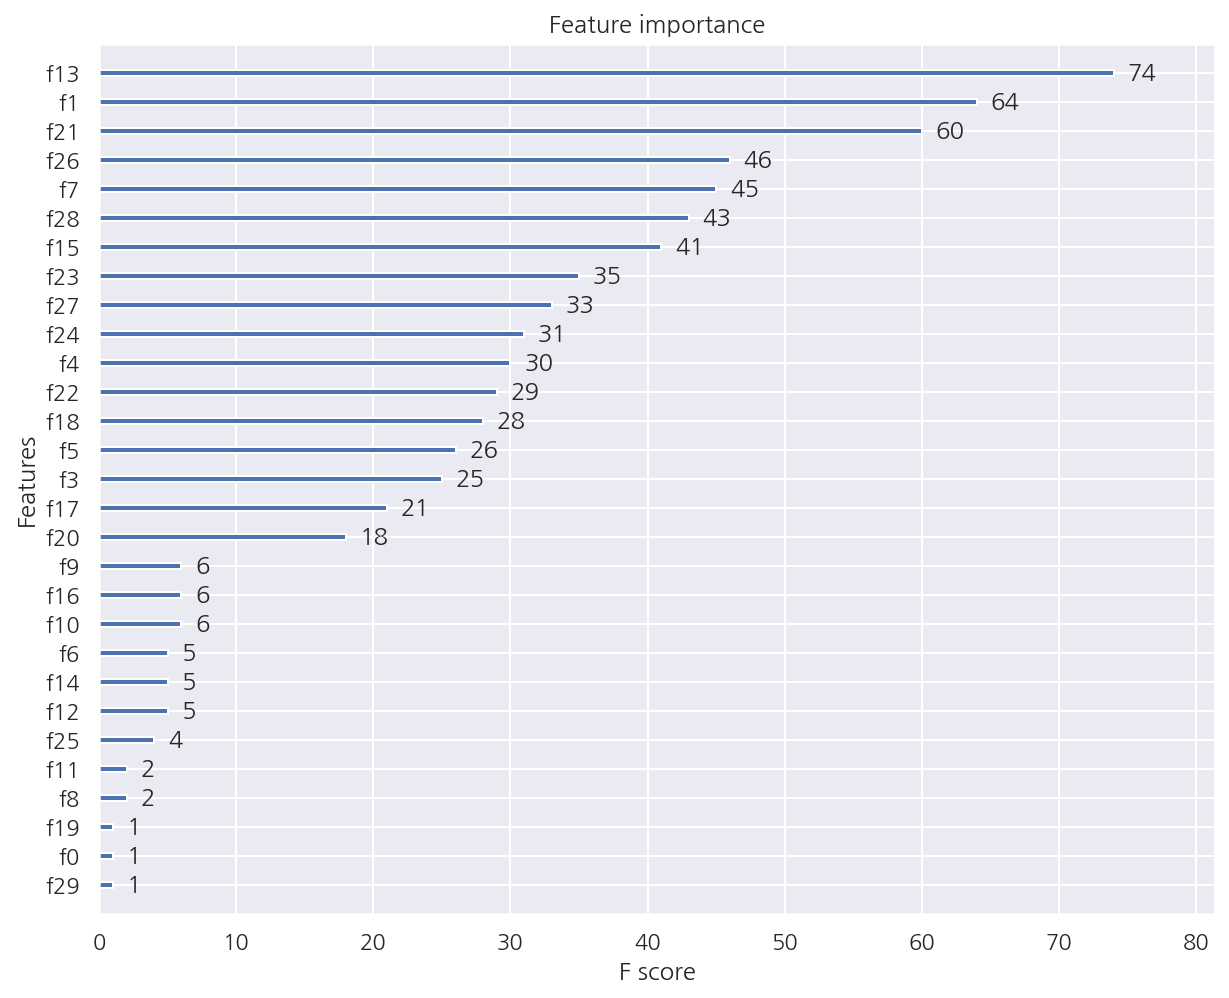

In [18]:
from xgboost import plot_importance

plot_importance(xgb_wrapper)
plt.show()

- `plot_importance`에 사이킷런 래퍼 클래스를 넣어도 잘 작동한다.


- `xgb_wrapper.feature_importances_`의 중요도와는 다르다.